# Binary Image Classfication Dog vs Cats
### TODOS:
####   Create a new archtikture 
####   Directorys for Pictures 
####   Image Generator for robust model
####   Complie 
####   fit model
####   accuracy  
####   save model

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory


2024-12-17 14:45:52.532529: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 14:45:52.539706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734443152.548155   17741 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734443152.550563   17741 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 14:45:52.559384: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Anzeigen der verfügbaren Geräte
devices = tf.config.list_physical_devices()
for device in devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


##### Set Dircetory for Images
----

In [ ]:
import os
import shutil
import pathlib

# Ursprünglicher Datenordner
original_dir = pathlib.Path("Data")  # Oberordner der Kategorien
new_base_dir = pathlib.Path("cats_vs_dogs_small")  # Zielbasisordner

def make_subset(subset_name, start_index, end_index):
    # Kategorien (Ordner: Cat und Dog)
    for category in ("Cat", "Dog"):
        # Neues Zielverzeichnis erstellen
        dir = new_base_dir / subset_name / category.lower()  # Kategorienamen in Kleinbuchstaben
        os.makedirs(dir, exist_ok=True)  # Ordner erstellen, falls nicht vorhanden

        # Bilder dieser Kategorie auswählen
        fnames = [f"{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            # Quell- und Zielpfade definieren
            src = original_dir / category / fname
            dst = dir / fname

            # Datei kopieren, wenn sie existiert
            if src.exists():
                shutil.copyfile(src, dst)

# Teilmengen erstellen
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)


In [3]:
train_dataset = image_dataset_from_directory(
    "cats_vs_dogs_small/train",
    image_size=(180, 180),
    batch_size=32)
    
validation_dataset = image_dataset_from_directory(
    "cats_vs_dogs_small/validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    "cats_vs_dogs_small/test",
    image_size=(180, 180),
    batch_size=32)

Found 1999 files belonging to 2 classes.


I0000 00:00:1734443161.710111   17741 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1291 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 1000 files belonging to 2 classes.
Found 1987 files belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1): #welches bild
    for i in range(9): # bilder anzahl
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1) # wie viele plots
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

In [ ]:
model.compile(loss="binary_crossentropy",
            optimizer="rmsprop",
            metrics=["accuracy"])

In [ ]:
callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="GPU_convnet_from_scratch_with_augmentation.keras",
save_best_only=True,
monitor="val_loss")
]

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)


In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

# Plotting
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model(
"model/GPU_convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Final Results is a accaruy in the test data of 0.838

In [1]:
import tensorflow as tf

# Modell laden
model_path = r"model/GPU_convnet_from_scratch_with_augmentation.keras"
convnet_from_scratch = tf.keras.models.load_model(model_path)

# Modell Zusammenfassung anzeigen
convnet_from_scratch.summary()

2024-12-12 10:37:44.357437: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 10:37:44.364461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733996264.372984    4496 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733996264.375466    4496 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 10:37:44.384647: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,982,084 (7.56 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 991,043 (3.78 MB)

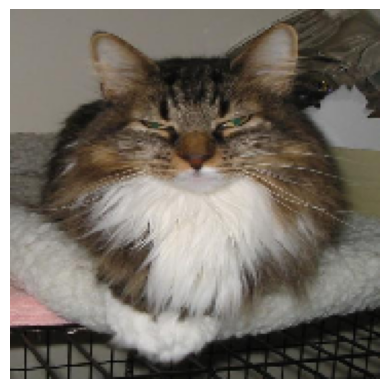

In [2]:
# Model nutzen
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Bild laden
image_path = r"cats_vs_dogs_small/test/cat/1504.jpg"

# Bild auf die gewünschte Eingabegröße skalieren unsere Modell nimmt 180 x 180 x3
img = image.load_img(image_path, target_size=(180, 180))

# Bild anzeigen
plt.imshow(img)
plt.axis("off")
plt.show()


In [3]:
# Das Bild in ein NumPy-Array umwandeln
img_array = image.img_to_array(img)
# Das Bild auf die Batch-Dimension erweitern (Modell erwartet eine Batch von Bildern)
img_array = np.expand_dims(img_array, axis=0)
print(img_array.shape)


(1, 180, 180, 3)


In [4]:
# Vorhersage mit dem geladenen Modell
prediction = convnet_from_scratch.predict(img_array)

# Vorhersage auswerten
# Da es eine binäre Klassifikation (Hund vs. Katze) ist:
if prediction[0] > 0.5:
    print("Das Bild zeigt einen Hund.")
else:
    print("Das Bild zeigt eine Katze.")

# Ausgabe der Vorhersagewahrscheinlichkeit
print("Vorhersagewahrscheinlichkeit für Hund:", prediction)


I0000 00:00:1733996272.795653   17767 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
Das Bild zeigt eine Katze.
Vorhersagewahrscheinlichkeit für Hund: [[0.04659241]]


more than two class image classification

In [ ]:
Create model

In [43]:
import os
def rename_pictures(image_path = str):
    for i, filename in enumerate(os.listdir(image_path)):
        os.rename(image_path + filename, image_path + str(i) + ".jpg")

rename_pictures("Data/Horses/")

In [44]:
import os
import shutil
import pathlib

# Ursprünglicher Datenordner
original_dir = pathlib.Path("Data")  # Oberordner der Kategorien
new_base_dir = pathlib.Path("cats_vs_dogs_vs_horses")  # Zielbasisordner

def make_subset(subset_name, start_index, end_index):
    # Kategorien (Ordner: Cat, Dog, Horses)
    for category in ("Cat", "Dog", "Horses"):
        # Neues Zielverzeichnis erstellen
        dir = new_base_dir / subset_name / category.lower()  # Kategorienamen in Kleinbuchstaben
        os.makedirs(dir, exist_ok=True)  # Ordner erstellen, falls nicht vorhanden

        # Bilder dieser Kategorie auswählen
        for i in range(start_index, end_index):
            # Versuche beide möglichen Dateiendungen (.jpg und .png)
            for ext in (".jpg", ".png"):
                fname = f"{i}{ext}"
                src = original_dir / category / fname
                dst = dir / fname

                # Datei kopieren, wenn sie existiert
                if src.exists():
                    shutil.copyfile(src, dst)
                    break  # Falls eine passende Datei gefunden wurde, zur nächsten Zahl wechseln

# Teilmengen erstellen
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=1862)


In [45]:
train_dataset = image_dataset_from_directory(
    "cats_vs_dogs_vs_horses/train",
    image_size=(180, 180),
    batch_size=32)
    
validation_dataset = image_dataset_from_directory(
    "cats_vs_dogs_vs_horses/validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    "cats_vs_dogs_vs_horses/test",
    image_size=(180, 180),
    batch_size=32)


Found 2999 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.
Found 1086 files belonging to 3 classes.


In [46]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [47]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [48]:
# Input of the model

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(3, activation="softmax")(x)
multiclass_model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
multiclass_model.summary()

In [ ]:
multiclass_model.compile(optimizer="adam", 
                         loss="sparse_categorical_crossentropy", 
                         metrics=["accuracy"])

callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="model/GPU_multiclass_model.keras",
save_best_only=True,
monitor="val_loss")
]


In [ ]:
with tf.device('/GPU:0'):
    history = multiclass_model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

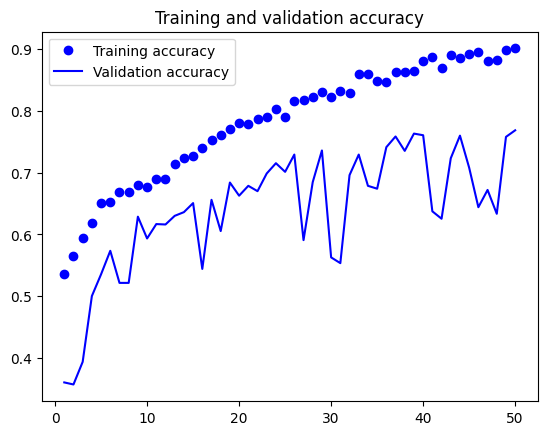

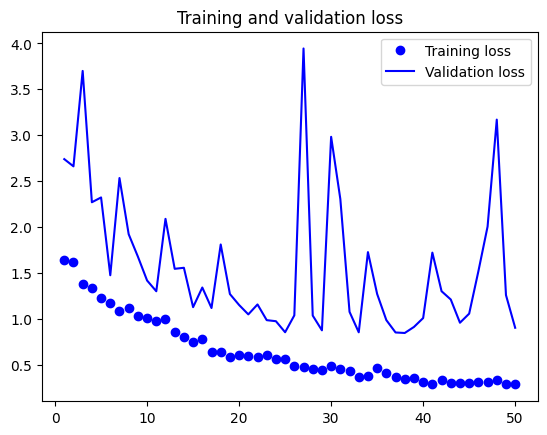

In [52]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

# Plotting
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [53]:
test_GPU_multiclass_model = keras.models.load_model(
"model/GPU_multiclass_model.keras")
test_loss, test_acc = test_GPU_multiclass_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

30/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7572 - loss: 0.8810

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7553 - loss: 0.8879
Test accuracy: 0.743


In [5]:
import tensorflow as tf

# Modell laden
model_path = "model/GPU_multiclass_model.keras"
GPU_multiclass_model = tf.keras.models.load_model(model_path)

# Modell Zusammenfassung anzeigen
#GPU_multiclass_model.summary()

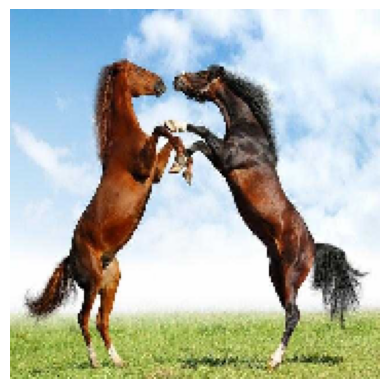

In [15]:
# Model nutzen
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Bild laden
image_path = "cats_vs_dogs_vs_horses/test/horses/1602.jpg"

# Bild auf die gewünschte Eingabegröße skalieren unsere Modell nimmt 180 x 180 x3
img = image.load_img(image_path, target_size=(180, 180))

# Bild anzeigen
plt.imshow(img)
plt.axis("off")
plt.show()


In [16]:
# Das Bild in ein NumPy-Array umwandeln
img_array = image.img_to_array(img)
# Das Bild auf die Batch-Dimension erweitern (Modell erwartet eine Batch von Bildern)
img_array = np.expand_dims(img_array, axis=0)
print(img_array.shape)


(1, 180, 180, 3)


In [17]:
import numpy as np

# Vorhersage mit dem geladenen Modell
prediction_GPU_multiclass_model = GPU_multiclass_model.predict(img_array)

# Klasse mit der höchsten Wahrscheinlichkeit auswählen
predicted_class = np.argmax(prediction_GPU_multiclass_model[0])

# Vorhersage auswerten
class_labels = ["Katze", "Hund", "Pferd"]  # Labels entsprechend den Klassen
print(f"Das Bild zeigt ein(e): {class_labels[predicted_class]}")

# Wahrscheinlichkeiten anzeigen
print("Vorhersagewahrscheinlichkeiten:", prediction_GPU_multiclass_model[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Das Bild zeigt ein(e): Pferd
Vorhersagewahrscheinlichkeiten: [8.9430640e-18 4.3003088e-15 1.0000000e+00]
